In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel, \
  BitsAndBytesConfig, GPTQConfig
import os

while "notebooks" in os.getcwd():
    os.chdir("..")

from time import time
from tqdm import tqdm
import torch
from langdetect import detect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login
from datasets import load_dataset
import math
from typing import List, Optional, Tuple, Union
from torch import nn
from tqdm import tqdm
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import gc
from sklearn.metrics import  roc_auc_score, average_precision_score

from src.utils import get_context_length, rolling_mean, \
    convert_to_json, score_json, get_text_whithin_braces  

from src.attention_saver import GUIDEModel
from src.influence.influence import Influence, AttentionRollout
tqdm.pandas()


import scienceplots
plt.style.use(['science','no-latex', 'grid'])

In [4]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    cache_dir = "/Data"    
)


base_model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.1",
    quantization_config = quantization_config,
    device_map="auto",
    attn_implementation="eager",
    cache_dir = "/Data"
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dataset = load_dataset("TheBritishLibrary/blbooks", "1510_1699", cache_dir = "/Data")['train']\
    .to_pandas()\
    [["record_id", "title", "text", "pg", "all_names", "Language_1"]]

dataset['context_length'] = dataset['text'].progress_apply(get_context_length, tokenizer=tokenizer)
dataset.record_id.nunique()
all_df = []

for book_id, df in dataset.groupby('record_id'):
    df['text'] = df['text'].cumsum()
    df['context_length'] = df['context_length'].cumsum()

    all_df.append(df)
books = pd.concat(all_df)
np.random.seed(42)
book_ids = np.random.choice(books.record_id.unique(), replace= False, size = 300)

100%|██████████| 51982/51982 [00:36<00:00, 1420.74it/s]


In [6]:
SCHEMA = '''{
    "title": "title of the story (string)", 
    "genre": string, 
    "characters": [{"name": string, "description": string. If not available set it to none} (one dict per character)], 
    "author": "the author of the story. If not available, set it to None", 
    "summary": "a brief summary of the story. Do not write more than 50 words",
    "date": "when the story was released (string)",
    "scenery": "where the story takes place (string)",
}
'''

TEMPLATE = '''
You are an assistant designed to provide information in JSON format. 
I will give you a story, and you need to extract and return specific details from the story. 
Do not output anything else than the JSON.

Your response should follow exactly this template: 

<schema>
{schema}
</schema>

{content}

'''

In [7]:
mask = books.record_id.isin(book_ids)
selected_books = books[mask].query("context_length <6000 & context_length > 500")

In [8]:
selected_books['prompt'] = selected_books\
    ['text']\
    .apply(lambda x: TEMPLATE.format(content = x, schema = SCHEMA))


sentence = "Your response should follow exactly this template:"
selected_books['instruction'] = sentence


df1= deepcopy(selected_books.query("context_length > 5500").iloc[1])

selected_books['prompt'] = selected_books\
    ['text']\
    .apply(lambda x: TEMPLATE.replace(sentence, sentence.upper()).format(content = x, schema = SCHEMA))

selected_books['instruction'] = sentence.upper()

df2 = deepcopy(selected_books.query("context_length > 5500").iloc[1])

selected_books = pd.concat([df1,df2], axis = 1).T

In [9]:
selected_books

,record_id,title,text,pg,all_names,Language_1,context_length,prompt,instruction
25755,000111406,"Πλουτοφθαλμια πλουτογαμια. A pleasant comedie,...","Tlhov]o(p$ct,\[Aa, TlKovJoya.iJ.ieti. ■ />s A ...",16,"Jaques, F. [person] ; F. J. [person] ; Randolp...",English,5651,\nYou are an assistant designed to provide inf...,Your response should follow exactly this templ...
25755,000111406,"Πλουτοφθαλμια πλουτογαμια. A pleasant comedie,...","Tlhov]o(p$ct,\[Aa, TlKovJoya.iJ.ieti. ■ />s A ...",16,"Jaques, F. [person] ; F. J. [person] ; Randolp...",English,5651,\nYou are an assistant designed to provide inf...,YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPL...


## Influence (ours)

In [10]:
N_LAYERS = 32
influence = Influence(
    base_model,
    tokenizer,
    N_LAYERS
)
results_raw = influence(
    selected_books.reset_index(),
    0,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt", 
    use_values=False
)

53 74
Forward propagation on instruction = YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPLATE:. Index = 1
Influence tokens : 53 to 74
Studying influence to 'YOUR RESPONSE SHOULD FOLLOW EXACTLY THIS TEMPLATE:'


Finished forward step in 6.302883148193359 s


100%|██████████| 32/32 [00:00<00:00, 70.76it/s]


Passing tensors to CPU...


In [11]:

results_delta = influence(
    selected_books.iloc[[0]].reset_index(),
    1,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
)

53 61
Forward propagation on instruction = Your response should follow exactly this template:. Index = 0
Influence tokens : 53 to 61
Studying influence to 'Your response should follow exactly this template:'
Finished forward step in 6.504551887512207 s


100%|██████████| 32/32 [00:00<00:00, 71.68it/s]


Passing tensors to CPU...


In [12]:

results_delta2 = influence(
    selected_books.iloc[[0]].reset_index(),
    2,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
)

53 61
Forward propagation on instruction = Your response should follow exactly this template:. Index = 0
Influence tokens : 53 to 61
Studying influence to 'Your response should follow exactly this template:'
Finished forward step in 6.602615594863892 s


100%|██████████| 32/32 [00:00<00:00, 71.57it/s]


Passing tensors to CPU...


In [19]:
rollout = AttentionRollout(
    base_model,
    tokenizer,
    32
)
results_rollout = rollout(
    selected_books.iloc[[0]].reset_index(),
    0,
    instruction_in_text=True,
    instruction_col="instruction",
    text_col="prompt"
) 

53 61
Forward propagation on instruction = Your response should follow exactly this template:. Index = 0
Influence tokens : 53 to 61
Studying influence to 'Your response should follow exactly this template:'
Finished forward step in 6.476023197174072 s


100%|██████████| 32/32 [00:00<00:00, 72.64it/s]


Passing tensors to CPU...


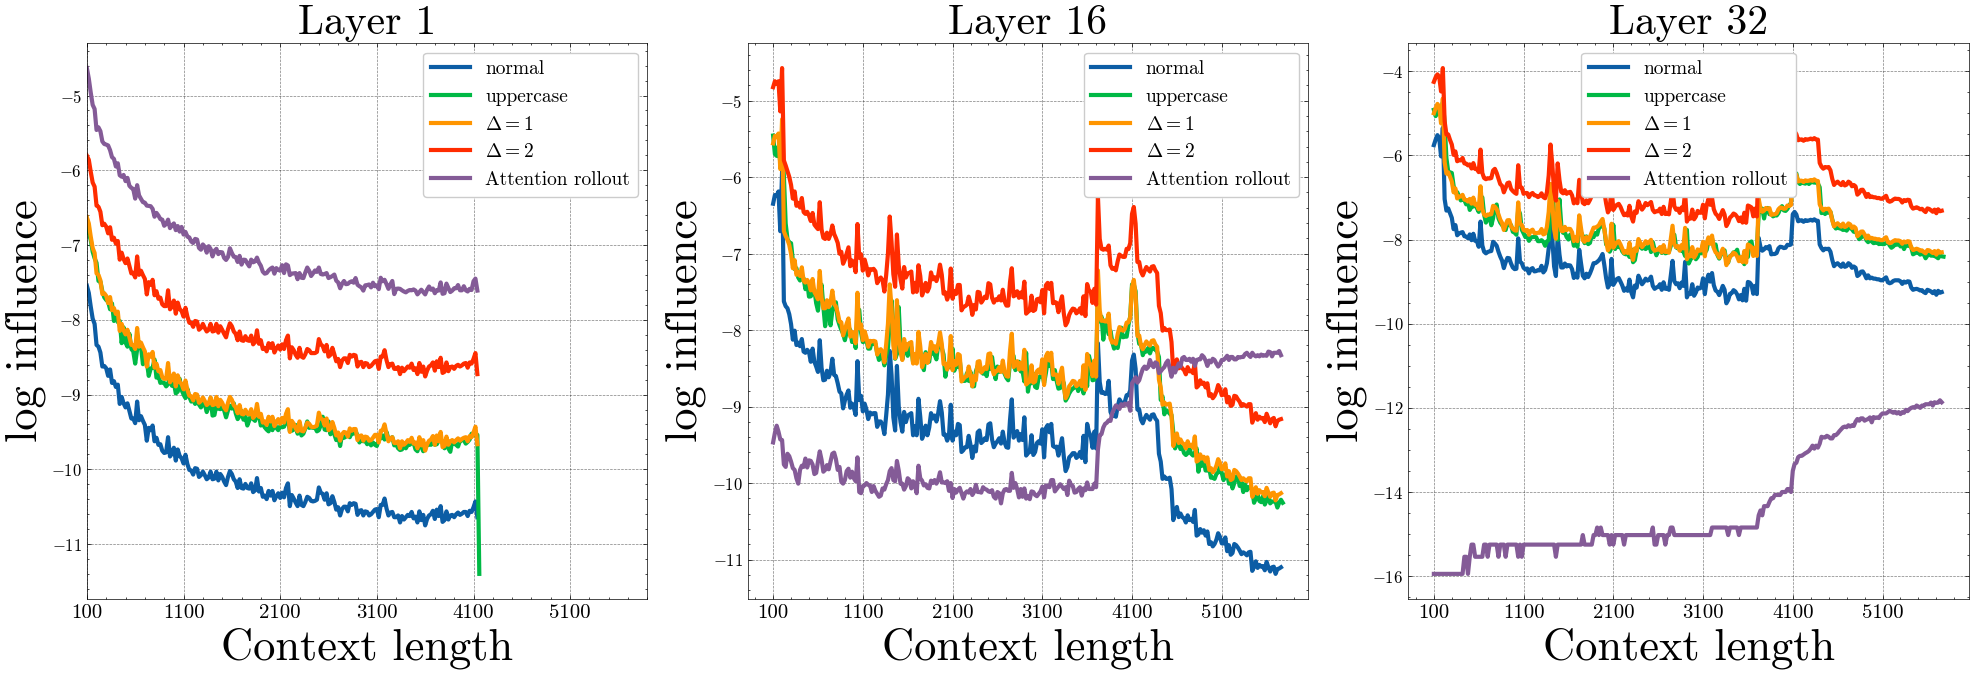

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 7))
plt.rc("font", size = 12)
kernel_size = 20

for id, ((text_id, instruction), values) in enumerate(results_raw.items()):
    influences = values['influences']
    axes[0].plot(
        torch.log(rolling_mean(influences[0], kernel_size)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )

    



    axes[1].plot(
        torch.log(rolling_mean(influences[15], kernel_size)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )


    axes[2].plot(
        torch.log(rolling_mean(influences[31], kernel_size)[5:]),
        label = "uppercase" if instruction.isupper() else "normal",
        linewidth = 3
    )

axes[0].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [0],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[1].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [15],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[2].plot(
    torch.log(
        
        rolling_mean(
            results_delta[list(results_delta.keys())[0]]\
                ['influences']\
                [31],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 1$"
)

axes[0].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [0],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)

axes[1].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [15],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)

axes[2].plot(
    torch.log(
        
        rolling_mean(
            results_delta2[list(results_delta.keys())[0]]\
                ['influences']\
                [31],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"$\Delta = 2$"
)

axes[0].plot(
    torch.log(
        
        rolling_mean(
            results_rollout[list(results_delta.keys())[0]]\
                ['influences']\
                [0],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"Attention rollout"
)

axes[1].plot(
    torch.log(
        
        rolling_mean(
            results_rollout[list(results_delta.keys())[0]]\
                ['influences']\
                [15],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"Attention rollout"
)

axes[2].plot(
    torch.log(
        
        rolling_mean(
            results_rollout[list(results_delta.keys())[0]]\
                ['influences']\
                [31],
            kernel_size
        )[5:]
    ), 
    linewidth = 3,
    label = r"Attention rollout"
)

axes[0].set_xlim([0, 5800/kernel_size])

label_fontsize = 32
legend_fontsize = 14
tick_fontsize = 20
title_fontsize = 30

axes[0].legend(prop= {"size" : legend_fontsize})
axes[1].legend(prop= {"size" : legend_fontsize})
axes[2].legend(prop= {"size" : legend_fontsize})

axes[0].set_title("Layer 1", fontsize = title_fontsize)
axes[1].set_title("Layer 16", fontsize =  title_fontsize)
axes[2].set_title("Layer 32", fontsize =  title_fontsize)
# axes[2].set_title("Layer 32")

axes[0].grid(True)
axes[1].grid(True)
axes[2].grid(True)


axes[0].set_xlabel("Context length", fontsize =  label_fontsize)
axes[0].set_ylabel("log influence", fontsize =  label_fontsize )

axes[1].set_xlabel("Context length", fontsize =  label_fontsize )
axes[1].set_ylabel("log influence", fontsize =  label_fontsize )

axes[2].set_xlabel("Context length", fontsize =  label_fontsize  )
axes[2].set_ylabel("log influence", fontsize =  label_fontsize  )

xticks = axes[0].get_xticks()
new_xticks = xticks * kernel_size + 100
axes[0].set_xticklabels(new_xticks.astype(int), fontsize = 15)

xticks = axes[1].get_xticks()
new_xticks = xticks * kernel_size + 100
axes[1].set_xticklabels(new_xticks.astype(int), fontsize = 15)

xticks = axes[2].get_xticks()
new_xticks = xticks * kernel_size + 100
axes[2].set_xticklabels(new_xticks.astype(int), fontsize = 15)


plt.tight_layout()
# plt.savefig("img/influence_ctx_len_delta.pdf")